In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# How nangs works

In this notebook we show how nangs works. We will solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = 0
\end{equation}

The independent variables (i.e, $x$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. 

In [1]:
# imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.__version__

'1.13.1'

## Define your dataset

To solve the PDE we will give samples of inputs to the NN. The following function will sample values randomly.

In [2]:
def get_samples(batch_size=100, n_inputs=2):
    # return torch.rand((batch_size, n_inputs), requires_grad=True)     
    return torch.rand((batch_size, n_inputs)) 

In [5]:
X = get_samples(5, 2)
x, t = X[:,0], X[:,1]

x, t

(tensor([0.9633, 0.3244, 0.2004, 0.1705, 0.4270]),
 tensor([0.8028, 0.3867, 0.3915, 0.6691, 0.4634]))

## Define your solution topology

We use a Multilayer Perceptron to approximate the solution to the PDE

In [6]:
import torch
import torch.nn as nn

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

mlp = nn.Sequential(
	nn.Linear(2, 100),
	Sine(), 
	nn.Linear(100, 100), 
	Sine(), 
	nn.Linear(100, 1)
)

mlp

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Sine()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sine()
  (4): Linear(in_features=100, out_features=1, bias=True)
)

In [7]:
# check output shape

output = mlp(X)

output.shape

torch.Size([5, 1])

## Boundary conditions

We can attempt to solve our PDE at this points, but we would obtain a trivial solution. Instead, we need to specify a set of boundary conditions.

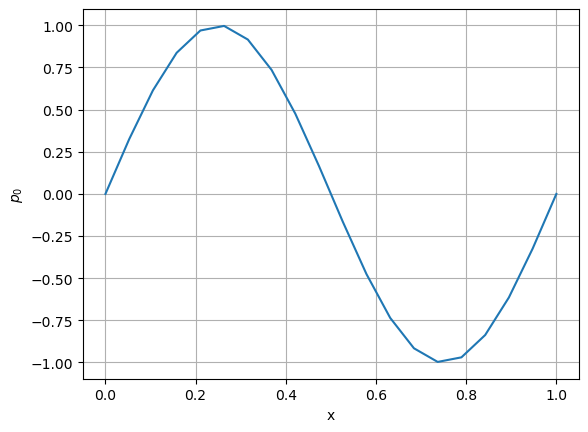

In [8]:
# initial condition (t = 0)

x= np.linspace(0, 1, 20)
p0 = np.sin(2*np.pi*x)

plt.plot(x, p0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$p_0$')
plt.show()

In [9]:
def get_samples_ini(batch_size=100):
    x = torch.rand(batch_size)
    p0 = torch.sin(2.*np.pi*x).unsqueeze(1)
    return torch.stack([  
        x,
        torch.zeros(batch_size)
    ], axis=-1), p0

In [10]:
# boundary conditions (peridic conditions at x = 0 and x = 1)

def get_samples_boco(batch_size=100):
    t = torch.rand(batch_size)
    X0 = torch.stack([  
        torch.zeros(batch_size),
        t
    ], axis=-1)
    X1 = torch.stack([  
        torch.ones(batch_size),
        t
    ], axis=-1)
    return X0, X1

## Solve the PDE

We can now proceed with solving the PDE

In [11]:
BATCH_SIZE = 100
N_STEPS = 5000
U = 1

optimizer = torch.optim.Adam(mlp.parameters())
criterion = torch.nn.MSELoss()

hist = []
log_each = 500
for step in range(1, N_STEPS+1):

    # optimize for PDE
    X = get_samples(BATCH_SIZE, 2) # N, (X, T)
    X.requires_grad_(True)
    y_hat = mlp(X) # N, P 
    grads, = torch.autograd.grad(y_hat, X, grad_outputs=y_hat.data.new(y_hat.shape).fill_(1), create_graph=True, only_inputs=True)
    dpdx, dpdt = grads[:,0], grads[:,1]
    pde_loss = criterion(dpdt, - U*dpdx)

    # optimize for initial condition
    X, p0 = get_samples_ini(BATCH_SIZE)
    y_hat = mlp(X) # N, P0 
    ini_loss = criterion(y_hat, p0)  
    
    # optimize for boundary conditions
    X0, X1 = get_samples_boco(BATCH_SIZE)
    y_0 = mlp(X0) 
    y_1 = mlp(X1)
    bound_loss = criterion(y_0, y_1)

    # update
    optimizer.zero_grad()
    loss = pde_loss + ini_loss + bound_loss
    loss.backward()
    optimizer.step()
   
    hist.append(loss.item())
    if step % log_each == 0:
        print(f'{step}/{N_STEPS} pde_loss {pde_loss.item():.5f} ini_loss {ini_loss.item():.5f} bound_loss {bound_loss.item():.5f}')

500/5000 pde_loss 0.00139 ini_loss 0.00347 bound_loss 0.00600
1000/5000 pde_loss 0.00046 ini_loss 0.00049 bound_loss 0.00106
1500/5000 pde_loss 0.00026 ini_loss 0.00009 bound_loss 0.00027
2000/5000 pde_loss 0.00012 ini_loss 0.00003 bound_loss 0.00005
2500/5000 pde_loss 0.00004 ini_loss 0.00001 bound_loss 0.00004
3000/5000 pde_loss 0.00004 ini_loss 0.00003 bound_loss 0.00003
3500/5000 pde_loss 0.00003 ini_loss 0.00001 bound_loss 0.00002
4000/5000 pde_loss 0.00003 ini_loss 0.00002 bound_loss 0.00002
4500/5000 pde_loss 0.00002 ini_loss 0.00002 bound_loss 0.00002
5000/5000 pde_loss 0.00002 ini_loss 0.00002 bound_loss 0.00003


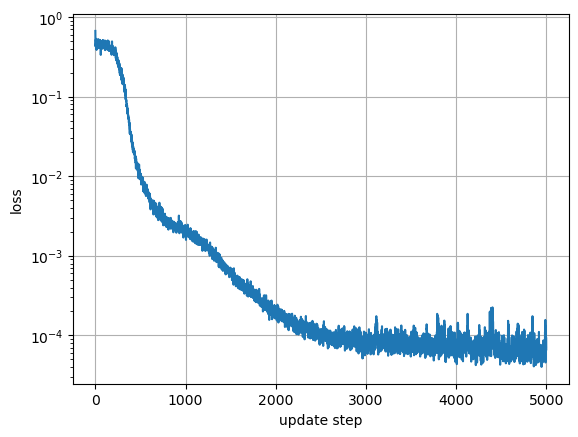

In [12]:
plt.plot(hist)
plt.xlabel("update step")
plt.ylabel("loss")
plt.yscale("log")
plt.grid(True)
plt.show()

## Evaluate your solution



In [13]:
def eval_model(N=10, t=0.):
    x = torch.linspace(0, 1, N)
    X = torch.stack([  # N0, (X, T = 0)
        x,
        torch.ones(N)*t
    ], axis=-1)
    mlp.eval()
    with torch.no_grad():
        p = mlp(X)
    return x.numpy(), p.numpy().ravel()

x, p = eval_model(N=20, t=0.5)

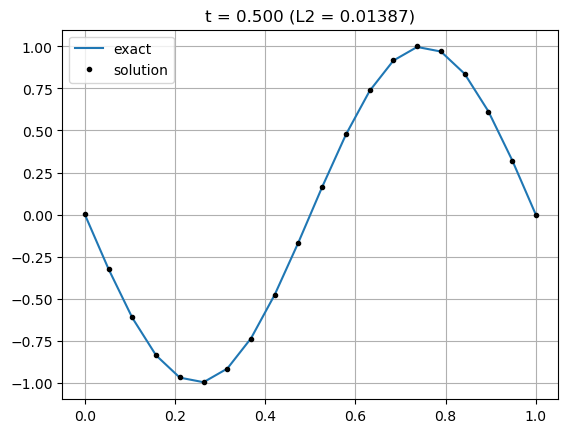

In [14]:
def plot_model(x, p, t):
    pe = np.sin(2.*np.pi*(x-U*t))
    plt.plot(x, pe, label="exact")
    plt.plot(x, p, '.k', label="solution")
    plt.legend()
    plt.grid(True)
    l2 = np.sqrt(np.sum((p-pe)**2))
    plt.title(f"t = {t:.3f} (L2 = {l2:.5f})")
    plt.show()
    
plot_model(x, p, 0.5)

## What nangs provides you

Nangs will provide you with classes and functions to abstract some of the concepts explained here in order to enable fast experimentation while allowing you to customize it to your needs.